# Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary # para ver los parametros y tamaños intermedios del modelo
from tqdm import tqdm # para graficar la barra de avance
import wandb # hacer log en whights and bias
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingWarmRestarts # modificar LR conforme se entrena

In [12]:
!pip install torchinfo
import torchinfo as torchinfo


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### configuramos el `device` acorde al device disponible




In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### nos vinculamos al weights and biases

In [4]:
# key de Marcos Uriel Maillot (lelectronfou@gmail.com), cámbiela a su usario una vez finalizada la clase.
wandb.login(key="d63a15806a812590a5525d000eed0e6d6c57a023")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\CIDIEE_NN\.netrc
wandb: Currently logged in as: lelectronfou (mmaillot) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.






## 1. Cargar base de datos

De la documentación, ver:


Transformación `torchvision.transforms.ToTensor()`

```
... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]...
```

Transformación `Normalize`

```
... Normalize a tensor image with mean and standard deviation. ...
```

In [5]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),#<---------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(), #<------------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [01:14<00:00, 133782.99it/s]


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 103467.13it/s]


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:12<00:00, 127065.62it/s]


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw



## 2. Ver que la base de datos esté OK

In [ ]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

In [ ]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")


Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])


tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


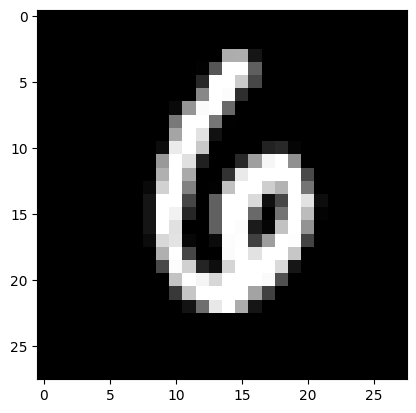

Label: 6


In [ ]:

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[5]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[5]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(-0.4242)
pixel maximo:  tensor(2.8088)
pixel minimo:  tensor(-0.4242)


## 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

argumentos a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling


la función pooling se elige directamente dentro del bloque!

In [6]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=3, p='same', s=1, pk=2):
    return torch.nn.Sequential(                               # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk)                                # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [39]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(c_in = n_channels, c_out = 16, k=9, p='same', s=1, pk=2)
    self.conv1_out = None
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv2 = conv_block(c_in = 16, c_out = 16, k=9, p='same', s=1, pk=2)
    self.conv2_out = None
    self.conv3 = conv_block(c_in = 16, c_out = 16, k=9, p='same', s=1, pk=2)
    self.fc = torch.nn.Linear(16*3*3, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)


  def forward(self, x):
    #print('input shape: ', x.shape)
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out
    y = y.flatten(start_dim=1)
    #print(y.shape)
    y = self.fc(y)
    return y


In [40]:
# instancio modelo
model = CNN()

# armo config (OJO!! NO ESTÁ AUTOMATIZADO!)
model_config = {
        "num_layers": 4,
        "kernel_size": 9,
        "dropout": 0.7,
        "n_channels": [16, 16, 16],
        "architecture": model.__class__.__name__
  }


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=144, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  5
Número total de parámetros a entrenar:  44266


In [41]:
model_config

{'num_layers': 4,
 'kernel_size': 9,
 'dropout': 0.7,
 'n_channels': [16, 16, 16],
 'architecture': 'CNN'}

## 4. Veamos que las dimensiones sean consistentes.

In [42]:
torchinfo.summary(model, input_size=( 12, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [12, 10]                  --
├─Sequential: 1-1                        [12, 16, 14, 14]          --
│    └─Conv2d: 2-1                       [12, 16, 28, 28]          1,312
│    └─Tanh: 2-2                         [12, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [12, 16, 14, 14]          --
├─Dropout2d: 1-2                         [12, 16, 14, 14]          --
├─Sequential: 1-3                        [12, 16, 7, 7]            --
│    └─Conv2d: 2-4                       [12, 16, 14, 14]          20,752
│    └─Tanh: 2-5                         [12, 16, 14, 14]          --
│    └─MaxPool2d: 2-6                    [12, 16, 7, 7]            --
├─Dropout2d: 1-4                         [12, 16, 7, 7]            --
├─Sequential: 1-5                        [12, 16, 3, 3]            --
│    └─Conv2d: 2-7                       [12, 16, 7, 7]            20,752
│   

## 5. Armo las funciones necesarias

In [24]:
def train_model_wandb(
        model,
        optimizer,
        train_loader,
        eval_loader,
        loss_module,
        config = model_config,
        scheduler_type="step",
        patience=3,
        patience_factor=0.01,
        num_epochs=3
):
    # Initialize Weights & Biases
    wandb.init(project="test", config=model_config)

    ## Set device
    model.to(device)

    # Set metric for callbacks
    best_eval = 0
    pt_epoch = 0

    for epoch in tqdm(range(num_epochs), desc="Epoch Progress"):
        ### Training Phase ###
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_samples = 0

        for batch_idx, data in enumerate(train_loader):

            X, y = data
            # Move input data to device (if using GPU)
            data_inputs = X.to(device)
            data_labels = y.to(device)

            # Forward pass
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)  # Ensure shape consistency

            # Compute loss
            loss = loss_module(preds, data_labels)

            # Zero gradients, backpropagate, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss for this batch
            batch_loss = loss.item()
            train_loss += batch_loss

            # Compute accuracy (assuming classification task)
            if preds.ndim == 2:  # Softmax case
                preds_classes = preds.argmax(dim=1)
            else:  # Sigmoid case (binary classification)
                preds_classes = (preds > 0.5).long()

            train_correct += (preds_classes == data_labels).sum().item()
            train_samples += data_labels.size(0)

            # Log batch-wise metrics
            wandb.log({
                "batch_loss": batch_loss,
                "batch_step": epoch * len(train_loader) + batch_idx,
                "batch_lr": optimizer.param_groups[0]['lr'],
            })

            # Step-level callback
            if scheduler_type=="step":
                scheduler.step()

        # Compute training metrics
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_samples

        ### Evaluation Phase ###
        model.eval()
        eval_loss = 0.0
        eval_correct = 0
        eval_samples = 0

        with torch.no_grad():  # Disable gradient tracking
            for data in eval_loader:

                X, y = data
                data_inputs = X.to(device)
                data_labels = y.to(device)

                preds = model(data_inputs)
                preds = preds.squeeze(dim=1)

                loss = loss_module(preds, data_labels)
                eval_loss += loss.item()

                if preds.ndim == 2:
                    preds_classes = preds.argmax(dim=1)
                else:
                    preds_classes = (preds > 0.5).long()

                eval_correct += (preds_classes == data_labels).sum().item()
                eval_samples += data_labels.size(0)

        # Compute evaluation metrics
        eval_loss /= len(eval_loader)
        eval_accuracy = eval_correct / eval_samples

        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} | Eval Loss: {eval_loss:.4f} - Eval Acc: {eval_accuracy:.4f}")

        # Callbacks
        ## Learning rate scheduler
        if scheduler_type=="epoch":
            scheduler.step()
        ## Early stopping
        if eval_accuracy>=best_eval*(1+patience_factor):
            best_eval = eval_accuracy
            pt_epoch = 0
        else:
            pt_epoch += 1
            if pt_epoch>=patience:
                print(f"Epoch {epoch+1}/{num_epochs} - Training interrupted due to early stopping condition.")
                wandb.finish()
                break
            else:
                print(f"Epoch {epoch+1}/{num_epochs} - Current epochs without validation metric improvement {pt_epoch}. {patience-pt_epoch} remaining before stopping.")

    # Finish W&B run
    wandb.finish()

In [43]:
# definimo optimizer y la función de pérdida
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
# paso al config el optimizador
model_config["optimizer"] = optimizer.__class__.__name__

# defino función de perdida
loss_fn = torch.nn.CrossEntropyLoss()


# Scheduler
scheduler_type = "step"
steps_per_epoch = len(dataloader['train'])
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=steps_per_epoch, T_mult=2, eta_min=1e-5)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=steps_per_epoch, mode="triangular2")

## Si queremos aplicar cambios al learning rate al final de cada epoch, usamos como ejemplo otro como este:
#scheduler_type = "epoch"
#scheduler = ExponentialLR(optimizer, gamma=0.99) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



##6. Entrenamiento WandB

In [44]:
# corremos la función de entrenamiento con todos los argumentos correspondientes
train_model_wandb(model, optimizer, dataloader['train'], dataloader['test'], loss_fn, scheduler_type=scheduler_type, num_epochs=15)

Epoch Progress:   7%|▋         | 1/15 [00:18<04:13, 18.09s/it]

Epoch 1/15 - Train Loss: 1.4575 - Train Acc: 0.5870 | Eval Loss: 0.8227 - Eval Acc: 0.7773


Epoch Progress:  13%|█▎        | 2/15 [00:36<03:56, 18.23s/it]

Epoch 2/15 - Train Loss: 0.7551 - Train Acc: 0.7918 | Eval Loss: 0.4327 - Eval Acc: 0.8733


Epoch Progress:  20%|██        | 3/15 [00:54<03:39, 18.26s/it]

Epoch 3/15 - Train Loss: 0.5608 - Train Acc: 0.8459 | Eval Loss: 0.3773 - Eval Acc: 0.8885


Epoch Progress:  27%|██▋       | 4/15 [01:12<03:19, 18.14s/it]

Epoch 4/15 - Train Loss: 0.4639 - Train Acc: 0.8715 | Eval Loss: 0.2645 - Eval Acc: 0.9206


Epoch Progress:  33%|███▎      | 5/15 [01:30<03:01, 18.18s/it]

Epoch 5/15 - Train Loss: 0.3774 - Train Acc: 0.8936 | Eval Loss: 0.2218 - Eval Acc: 0.9323


Epoch Progress:  40%|████      | 6/15 [01:49<02:44, 18.23s/it]

Epoch 6/15 - Train Loss: 0.3375 - Train Acc: 0.9043 | Eval Loss: 0.2048 - Eval Acc: 0.9386
Epoch 6/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  47%|████▋     | 7/15 [02:07<02:25, 18.22s/it]

Epoch 7/15 - Train Loss: 0.3203 - Train Acc: 0.9090 | Eval Loss: 0.1994 - Eval Acc: 0.9396
Epoch 7/15 - Current epochs without validation metric improvement 2. 1 remaining before stopping.


Epoch Progress:  53%|█████▎    | 8/15 [02:24<02:06, 18.00s/it]

Epoch 8/15 - Train Loss: 0.3044 - Train Acc: 0.9121 | Eval Loss: 0.1747 - Eval Acc: 0.9452


Epoch Progress:  60%|██████    | 9/15 [02:42<01:48, 18.00s/it]

Epoch 9/15 - Train Loss: 0.2746 - Train Acc: 0.9199 | Eval Loss: 0.1556 - Eval Acc: 0.9514
Epoch 9/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  67%|██████▋   | 10/15 [03:00<01:29, 17.98s/it]

Epoch 10/15 - Train Loss: 0.2548 - Train Acc: 0.9258 | Eval Loss: 0.1451 - Eval Acc: 0.9545
Epoch 10/15 - Current epochs without validation metric improvement 2. 1 remaining before stopping.


Epoch Progress:  73%|███████▎  | 11/15 [03:18<01:11, 17.94s/it]

Epoch 11/15 - Train Loss: 0.2416 - Train Acc: 0.9283 | Eval Loss: 0.1378 - Eval Acc: 0.9556


Epoch Progress:  80%|████████  | 12/15 [03:36<00:53, 17.85s/it]

Epoch 12/15 - Train Loss: 0.2274 - Train Acc: 0.9333 | Eval Loss: 0.1323 - Eval Acc: 0.9573
Epoch 12/15 - Current epochs without validation metric improvement 1. 2 remaining before stopping.


Epoch Progress:  87%|████████▋ | 13/15 [03:54<00:35, 17.93s/it]

Epoch 13/15 - Train Loss: 0.2244 - Train Acc: 0.9334 | Eval Loss: 0.1294 - Eval Acc: 0.9581
Epoch 13/15 - Current epochs without validation metric improvement 2. 1 remaining before stopping.
Epoch 14/15 - Train Loss: 0.2194 - Train Acc: 0.9356 | Eval Loss: 0.1282 - Eval Acc: 0.9582
Epoch 14/15 - Training interrupted due to early stopping condition.


batch_loss,█▄▄▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂
batch_lr,▅▅▄▃▁▅▅▄▄▃██▇▇▆▆▆▅▅▅▄▃▂▂▁██▇▇▆▅▅▄▃▃▂▂▂▂▁
batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
eval_accuracy,▁▅▅▇▇▇▇▇██████
eval_loss,█▄▄▂▂▂▂▁▁▁▁▁▁▁
learning_rate,█▄█▇▄▂██▇▆▄▃▂▁
train_accuracy,▁▅▆▇▇▇▇███████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁
batch_loss,0.12082
batch_lr,1e-05


Epoch Progress:  87%|████████▋ | 13/15 [04:13<00:39, 19.52s/it]


## 7. Vemos que funcione.

torch.Size([1, 28, 28])
tensor(-0.4242)
tensor(2.8215)
tensor(-0.4242)


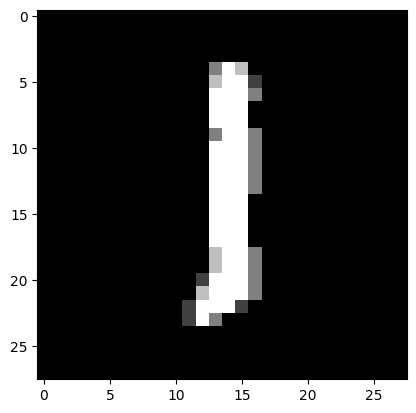

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-2.2373,  5.4469, -0.6796,  0.2946, -0.8774, -0.0928, -0.0867, -0.0913,
          0.2713, -0.3452]], device='cuda:0')

softmax de predicción:
tensor([[4.4632e-04, 9.7018e-01, 2.1191e-03, 5.6137e-03, 1.7388e-03, 3.8108e-03,
         3.8338e-03, 3.8165e-03, 5.4846e-03, 2.9607e-03]], device='cuda:0')

El numero es un:  1


In [ ]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 14

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.to(device)
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())
